In [31]:
%load_ext autoreload
%autoreload 2

import torch
import numpy as np
import matplotlib.pyplot as plt
from gradient_loader import load_stacked_gradients, load_gradients_by_batch

# Configuration
GRADIENTS_DIR = "results/gradients"
EPOCH_TO_LOAD = 0

print(f"Loading gradients from: {GRADIENTS_DIR}")
print(f"Epoch: {EPOCH_TO_LOAD}")

torch.set_grad_enabled(False)

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload
Loading gradients from: results/gradients
Epoch: 0


In [32]:
stacked_gradients = load_stacked_gradients(GRADIENTS_DIR, EPOCH_TO_LOAD)
print(f"\n✅ Successfully loaded gradients for {len(stacked_gradients)} parameters")

# Show what we loaded
for param_name, gradients in stacked_gradients.items():
    print(f"  {param_name}: {gradients.shape}")

Loaded metadata: {'epoch': 0, 'batch_idx': 478, 'total_samples': 4, 'parameter_names': ['network.0.weight', 'network.0.bias', 'network.3.weight', 'network.3.bias']}
Found 1916 gradient files


Concatenating gradients from all batches...
Successfully loaded 4 parameters
  network.0.weight: torch.Size([30596, 32, 784]) (2928.13 MB)
  network.0.bias: torch.Size([30596, 32]) (3.73 MB)
  network.3.weight: torch.Size([30596, 5, 32]) (18.67 MB)
  network.3.bias: torch.Size([30596, 5]) (0.58 MB)
Total memory: 2951.13 MB

✅ Successfully loaded gradients for 4 parameters
  network.0.weight: torch.Size([30596, 32, 784])
  network.0.bias: torch.Size([30596, 32])
  network.3.weight: torch.Size([30596, 5, 32])
  network.3.bias: torch.Size([30596, 5])


🔍 GPU-Accelerated K-means Clustering Analysis
Analyzing parameter: network.3.weight
Gradient tensor shape: torch.Size([30596, 5, 32])
Digit filtering detected: [0, 1, 2, 3, 4]
Automatically setting n_clusters = 5 to match filtered digits

2. Performing GPU-accelerated k-means clustering with 5 clusters...
Performing GPU-accelerated k-means clustering on gradients tensor of shape torch.Size([30596, 5, 32])
Number of clusters: 5
Initialization method: random
Device: cuda:0
Using batches from 20.0% to 100.0% for clustering
Minimum gradient norm percentile: 0.5%
Clustering on 24477 batches (indices 6119 to 30595) out of 30596 total batches
Gradient norm percentile threshold: 0.0003
Filtered to 24354 gradients (out of 24477) with norm >= 0.0003
Final clustering shape: torch.Size([24354, 160])
Memory usage: 14.86 MB
Running k-means with 1 different initializations...


K-means initializations: 100%|██████████| 1/1 [00:00<00:00, 37.88it/s]

Clustering completed in 0.03 seconds
Assigning all original batches to clusters...

Clustering Results Summary:
  Inertia: 259044.56
  Cluster sizes: {0: 375, 1: 563, 2: 28847, 3: 662, 4: 149}
  Clustering performed on 24354/24477 batches in subset (99.5%)
  Subset: 24477/30596 total batches (80.0%)

3. Plotting clustering results...


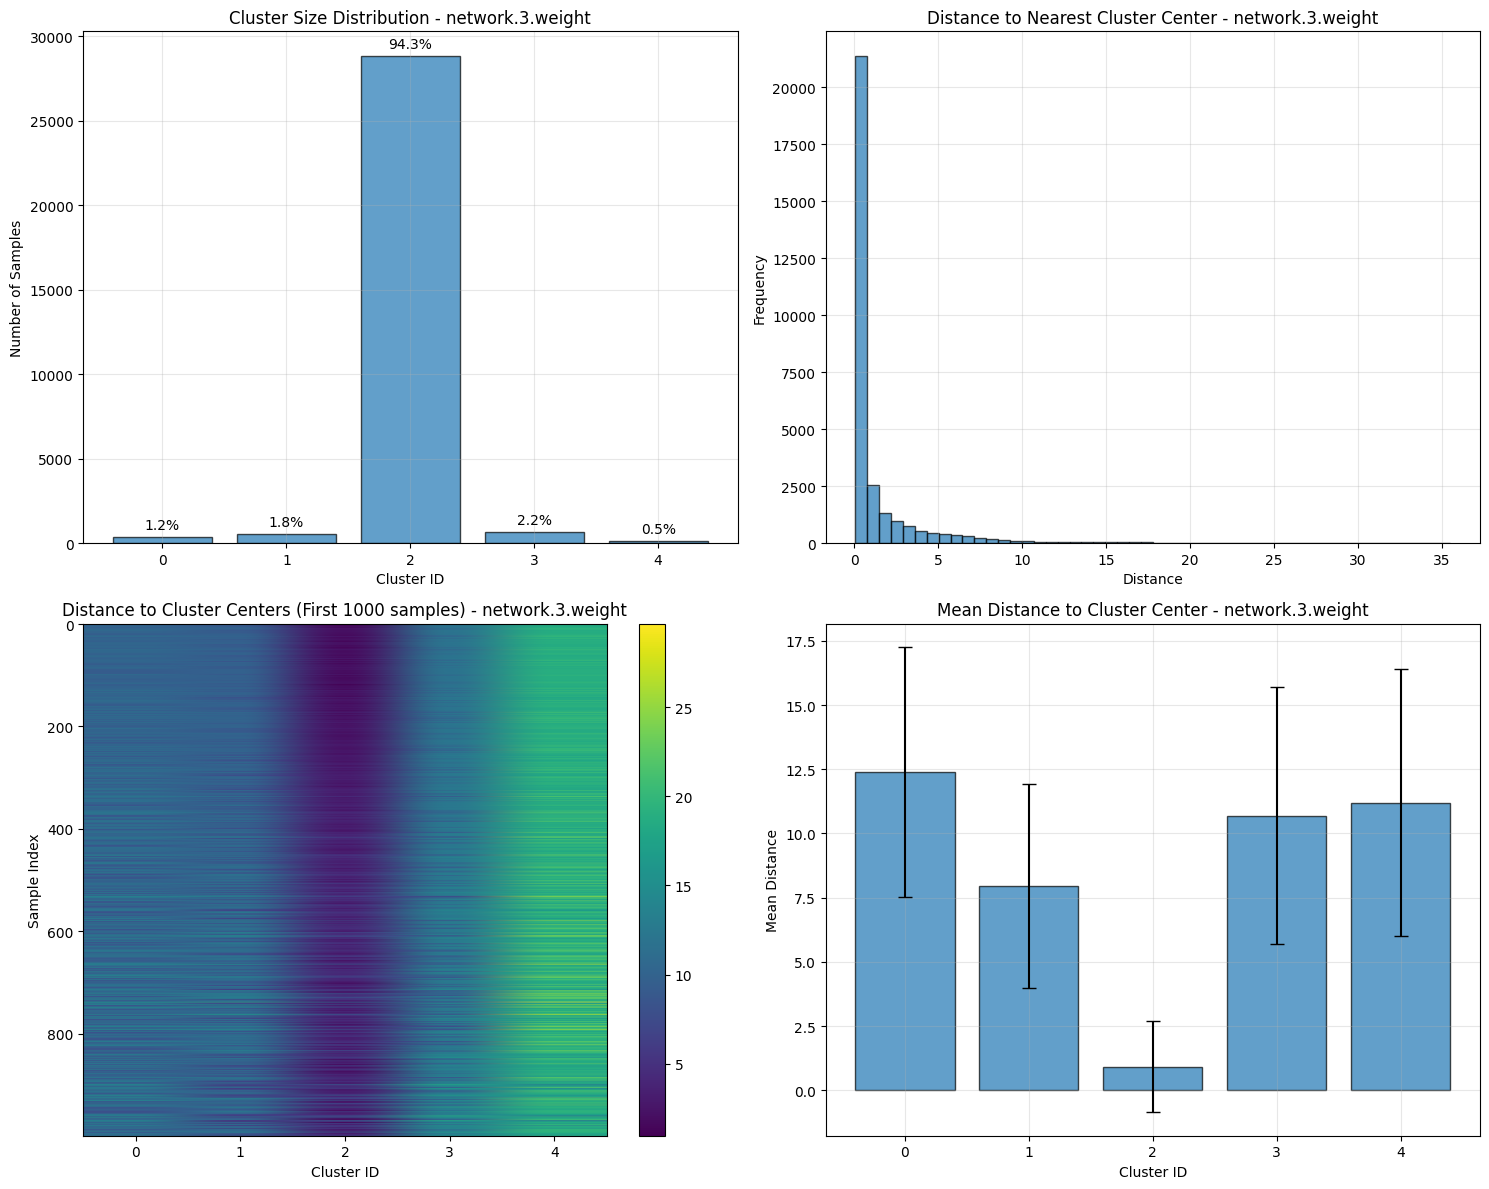

In [33]:
# Import the k-means clustering utilities and config
from k_means import kmeans_gradients, plot_clustering_results, analyze_cluster_characteristics, find_optimal_clusters
from config import Config

# Check if we have loaded gradients
if 'stacked_gradients' in locals() and stacked_gradients:
    print("🔍 GPU-Accelerated K-means Clustering Analysis")
    print("=" * 50)
    
    # Load config to check for digit filtering
    config = Config()
    
    # Pick a parameter to analyze (you can change this)
    param_name = list(stacked_gradients.keys())[2]
    gradients_tensor = stacked_gradients[param_name]

    print(f"Analyzing parameter: {param_name}")
    print(f"Gradient tensor shape: {gradients_tensor.shape}")
    
    # Automatically determine number of clusters based on filtering
    if config.filter_digits is not None:
        n_clusters = len(config.filter_digits)
        print(f"Digit filtering detected: {config.filter_digits}")
        print(f"Automatically setting n_clusters = {n_clusters} to match filtered digits")
    else:
        n_clusters = 10  # Default for all digits
        print("No digit filtering - using default n_clusters = 10")
    
    # Perform k-means clustering (with progress bar)
    print(f"\n2. Performing GPU-accelerated k-means clustering with {n_clusters} clusters...")
    clustering_results = kmeans_gradients(
        gradients_tensor.cuda(), 
        n_clusters=n_clusters,
        use_gpu=True,
        max_iter=1000,
        n_init=1,
        init_method="random",
        start_fraction=0.2,
        end_fraction=1,
        min_grad_percentile=0.5
        )
    
    # Plot comprehensive results
    print(f"\n3. Plotting clustering results...")
    plot_clustering_results(clustering_results, param_name)

param_name network.3.weight


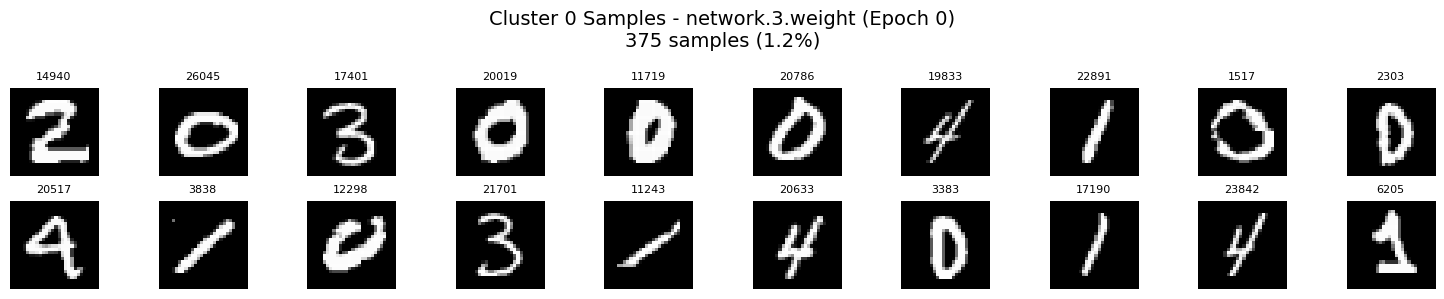


Cluster 0 Statistics for network.3.weight (Epoch 0):
  Size: 375 samples (1.2%)
  Sample indices: [14940, 26045, 17401, 20019, 11719, 20786, 19833, 22891, 1517, 2303, 20517, 3838, 12298, 21701, 11243, 20633, 3383, 17190, 23842, 6205]


In [38]:
# Import the visualization utilities
from cluster_visualization import visualize_cluster_samples, visualize_cluster_centers, analyze_cluster_diversity, visualize_specific_cluster

print("param_name", param_name)

# Example usage - replace with your actual clustering results
epoch = 0  # Images are saved for epoch 0

c=0
visualize_specific_cluster(clustering_results, param_name, epoch, num_samples=20, cluster_id=c)

🎨 Creating t-SNE Visualization
Digit filtering detected: [0, 1, 2, 3, 4]
t-SNE will show original digits for better visualization
Creating t-SNE visualization for: network.3.weight
Using clustering results with 5 clusters
Creating t-SNE visualization for network.3.weight (epoch 0)
Loaded metadata: {'epoch': 0, 'batch_idx': 478, 'total_samples': 4, 'parameter_names': ['network.0.weight', 'network.0.bias', 'network.3.weight', 'network.3.bias']}
Found 1916 gradient files


Concatenating gradients from all batches...
Successfully loaded 4 parameters
  network.0.weight: torch.Size([30596, 32, 784]) (2928.13 MB)
  network.0.bias: torch.Size([30596, 32]) (3.73 MB)
  network.3.weight: torch.Size([30596, 5, 32]) (18.67 MB)
  network.3.bias: torch.Size([30596, 5]) (0.58 MB)
Total memory: 2951.13 MB
Loaded gradients tensor: torch.Size([30596, 5, 32])
Using 5000 samples for t-SNE
Loading true labels...
Loading model predictions...
Predictions file not found: results/gradients/model_predictions_epoch_0.pt
Applying PCA for dimensionality reduction...
Reduced from 160 to 50 dimensions
Applying t-SNE...
Saved t-SNE visualization to: results/tsne_visualization_network_3_weight_epoch_0.png


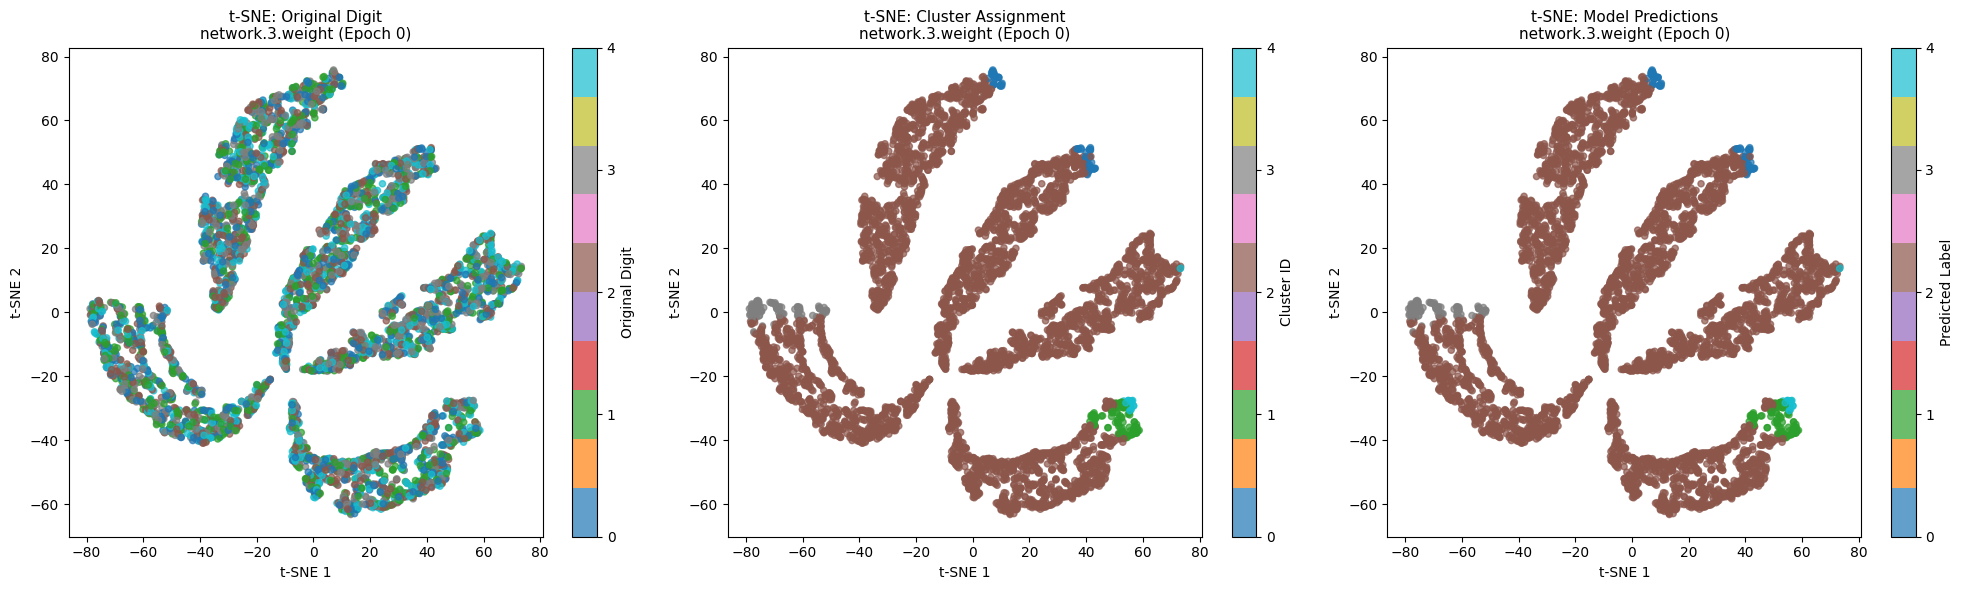


t-SNE Visualization Statistics:
  Parameter: network.3.weight
  Epoch: 0
  Samples used: 5000
  Number of clusters: 5
  t-SNE perplexity: 30

Label-Cluster Correspondence:
  Cluster 0: Dominant true label 0 (29.0%)
  Cluster 1: Dominant true label 1 (23.0%)
  Cluster 2: Dominant true label 1 (21.2%)
  Cluster 3: Dominant true label 2 (24.8%)
  Cluster 4: Dominant true label 4 (34.8%)

Prediction-Cluster Correspondence:
  Cluster 0: Dominant prediction 0 (100.0%)
  Cluster 1: Dominant prediction 1 (100.0%)
  Cluster 2: Dominant prediction 2 (100.0%)
  Cluster 3: Dominant prediction 3 (100.0%)
  Cluster 4: Dominant prediction 4 (100.0%)

Overall Model Accuracy on Sample: 20.8%

✅ t-SNE visualization completed!
The visualization shows:
  - Left: Points colored by true MNIST digit labels (original digits if filtered)
  - Middle: Points colored by k-means cluster assignments
  - Right: Points colored by model predictions

Note: If true labels or predictions are missing, cluster labels will

In [39]:
# Import t-SNE visualization function and config
from cluster_visualization import visualize_tsne_gradients
from config import Config

# Create t-SNE visualization using the clustering results from above
print("🎨 Creating t-SNE Visualization")
print("=" * 40)

# Load config to check for digit filtering
config = Config()
if config.filter_digits is not None:
    print(f"Digit filtering detected: {config.filter_digits}")
    print("t-SNE will show original digits for better visualization")
else:
    print("No digit filtering - showing all digits")

# Use the same parameter and clustering results from Cell 2
print(f"Creating t-SNE visualization for: {param_name}")
print(f"Using clustering results with {clustering_results['n_clusters']} clusters")

# Create the t-SNE visualization
# This will create three plots: true labels, cluster assignments, and model predictions
visualize_tsne_gradients(
    clustering_results=clustering_results,
    param_name=param_name,
    epoch=EPOCH_TO_LOAD,
    data_dir=GRADIENTS_DIR,
    n_samples=5000,  # Use 5000 samples for good performance
    perplexity=30,   # Good default for t-SNE
    random_state=42, # For reproducibility
    figsize=(20, 6), # Wide figure to show all three plots
    config=config    # Pass config for filtering info
)

print("\n✅ t-SNE visualization completed!")
print("The visualization shows:")
print("  - Left: Points colored by true MNIST digit labels (original digits if filtered)")
print("  - Middle: Points colored by k-means cluster assignments") 
print("  - Right: Points colored by model predictions")
print("\nNote: If true labels or predictions are missing, cluster labels will be used as fallback.")